# Metal Surface Defects classification
This notebook presents a deep learning approach for detecting surface defects in metal components using convolutional neural networks (CNNs). The project was carried out as part of the **Deep Learning** course in the MSc in Data Science, jointly offered by the **National Centre for Scientific Research "Demokritos"** and the **University of the Peloponnese**.

**Contributors**: Haris Sideris, Apostolis Tsergas, Nikos Nteits

---

## Project Overview

The aim of this project is to explore different approaches to defect classification:
- Building CNN models from scratch
- Applying transfer learning with various configurations
- Evaluating performance across two datasets: NEU and X-SDD
- Analyzing how model architecture and training strategy affect accuracy

---

## Getting Started

Before running this notebook, ensure you have the necessary libraries installed. You can do this by running:

```bash
pip install -r requirements.txt
```

The requirements file contains all necessary dependencies for running the code and reproducing the results.

---

## How to Use This Notebook

This notebook is organized into four main parts, each representing a different experimental phase:

1. **From Scratch Learning – 1st Dataset**
   - Load Dataset
   - Transform Images
   - Define Neural Network Architecture
   - Training and Validation
   - Testing and Visualization

2. **Transfer Learning – 1 fc layer unfrozen**
   - Load Dataset
   - Transform Images
   - Modify Pretrained Network (unfreeze 1 layer)
   - Training and Validation
   - Testing

3. **Transfer Learning – 2 fc layers unfrozen**
   - Modify Pretrained Network (unfreeze 2 layers)
   - Training and Validation
   - Testing

4. **From Scratch Learning – 2nd Dataset**
   - Training and Validation
   - Testing

---
### CNN Architecture Overview

We designed a custom CNN model consisting of 4 convolutional blocks followed by fully connected layers. Each block includes:

- A 2D convolutional layer with padding
- Batch normalization
- ReLU activation
- Max pooling

The final structure includes:

- Input: 1 × 64 × 64 (grayscale image)
- Conv1: 1 → 8 channels (Output: 8 × 64 × 64)
- MaxPool1: → 8 × 32 × 32
- Conv2: 8 → 16 channels → MaxPool → 16 × 16 × 16
- Conv3: 16 → 32 channels → MaxPool → 32 × 8 × 8
- Conv4: 32 → 64 channels → MaxPool → 64 × 4 × 4
- Flatten: 64 × 4 × 4 = 1024 features
- FC1: 1024 → 64
- FC2: 64 → 6 (number of classes)

The total number of parameters is approximately **90,000**. This model is lightweight and fast, suitable for small datasets like NEU and X-SDD.

---
### Image Preprocessing and Resizing Choice

All images were converted to grayscale, normalized, and resized to **64×64** pixels. Although we assume that every photo whould be in grayscale zone, we did to be safe.

After experimenting with various image sizes (e.g., 128×128, 200×200), we concluded that **64×64** was sufficient due to:

- The highly **descriptive nature of the defects**
- The **high contrast** and consistent lighting in the dataset
- The relatively **simple patterns** that do not require fine-grained features

We proceeded with this small size, as the smaller size significantly reduces computational cost while preserving classification performance.

---

### Datasets Used

#### 1. **NEU Metal Surface Defects Dataset**
- Path used in notebook:  
  `https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data/data`
- Structured folder format (one folder per class)
- **Classes**:  
  `['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']`
- **Image counts**:
  - Training: 1,656
  - Validation: 72
  - Test: 72

This dataset is clean and highly structured, making it ideal for baseline CNN training from scratch.


#### 2. **X-SDD (Steel Surface Defect Dataset)**
- Path used in notebook (via Kaggle Hub):  
  `https://www.kaggle.com/datasets/sayelabualigah/x-sdd/data`
- Unstrustured folders
- **Classes**:
  `['finishing roll printing', 'iron sheet ash', 'oxide scale of plate system', 'oxide scale of temperature system', 'red iron', 'slag inclusion', 'surface scratch']`
- **Image counts**:
  - Training: 951
  - Validation: 204
  - Test: 205

This dataset is more challenging due to class imbalance, visual overlap, and less consistent formatting — making it well-suited for testing transfer learning techniques.

---

### Evaluation and Observations

The CNN trained from scratch on the NEU dataset achieved **100% accuracy**, suggesting that the task is relatively simple with clean and clearly separated classes.

On the more complex X-SDD dataset:
- A from-scratch model achieved **91.71%**
- Transfer learning with only 1 fc layer unfrozen gave **78.05%**
- Unfreezing 2 fc layers improved accuracy to **90.73%**

These results show that for clean, well-structured data, even simple CNNs trained from scratch can be highly effective. However, transfer learning becomes valuable for more diverse datasets.

---
### Conclusions and Future Work

This project demonstrates how CNNs and transfer learning can be applied to real-world defect detection problems. The simplicity of the NEU dataset allowed us to understand the behavior of our models clearly.

**Next Steps**:
- Use larger and more complex datasets (>10k images)
- Explore other architectures (e.g., ResNet)
- Use ensemble models for better generalization

All models and experiments are reproducible using the provided notebook and requirements file. Below you could find the cells with the scripts with several markdowns in each chapter. Also the py script is provided with less visual results than the notebook.



# **From Scratch Learning -1st Dataset**

In this section, we build and train a convolutional neural network from scratch on the NEU surface defect dataset. This serves as our baseline model.

- Trained on grayscale images (64×64)
- Custom CNN architecture
- Achieved 100% accuracy on the test set

## Load Dataset

In [ ]:
import kagglehub

data_dir = kagglehub.dataset_download("fantacher/neu-metal-surface-defects-data")

root_dir = "/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data"
print("Path to dataset files:", root_dir)

Path to dataset files: /kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data


## Transform Images

In [ ]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

g = torch.Generator().manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.ImageFolder(root=os.path.join(root_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(root=os.path.join(root_dir, 'valid'), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(root_dir, 'test'), transform=transform)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    worker_init_fn=seed_worker, generator=g
)

val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    worker_init_fn=seed_worker, generator=g
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    worker_init_fn=seed_worker, generator=g
)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Classes: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
Train samples: 1656
Validation samples: 72
Test samples: 72


## Neural Network Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_prob)

        self.fc1  = nn.Linear(64 * 4 * 4, 64)
        self.fc2  = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv -> BN -> ReLU -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

## Training - Validation

In [ ]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs,model_save_name):
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        val_loss = val_loss / len(valid_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Save best model state
    torch.save(best_model_state, f'{model_save_name}.pth')

    return train_losses, val_losses


In [ ]:
# Train and get losses
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50,model_save_name='Neu_scratch')

Epoch 1, Train Loss: 0.9094, Val Loss: 0.7960, Train Acc: 0.6733, Val Acc: 0.5417
Epoch 2, Train Loss: 0.3792, Val Loss: 0.1486, Train Acc: 0.8829, Val Acc: 0.9306
Epoch 3, Train Loss: 0.2825, Val Loss: 0.0519, Train Acc: 0.9058, Val Acc: 1.0000
Epoch 4, Train Loss: 0.2436, Val Loss: 0.0463, Train Acc: 0.9136, Val Acc: 0.9861
Epoch 5, Train Loss: 0.1758, Val Loss: 0.1144, Train Acc: 0.9414, Val Acc: 0.9306
Epoch 6, Train Loss: 0.1620, Val Loss: 0.0413, Train Acc: 0.9487, Val Acc: 1.0000
Epoch 7, Train Loss: 0.1272, Val Loss: 0.0243, Train Acc: 0.9547, Val Acc: 1.0000
Epoch 8, Train Loss: 0.1175, Val Loss: 0.0290, Train Acc: 0.9638, Val Acc: 0.9861
Epoch 9, Train Loss: 0.0859, Val Loss: 0.0039, Train Acc: 0.9734, Val Acc: 1.0000
Epoch 10, Train Loss: 0.0722, Val Loss: 0.0098, Train Acc: 0.9734, Val Acc: 1.0000
Epoch 11, Train Loss: 0.0683, Val Loss: 0.0030, Train Acc: 0.9825, Val Acc: 1.0000
Epoch 12, Train Loss: 0.0839, Val Loss: 0.0492, Train Acc: 0.9698, Val Acc: 0.9722
Epoch 13, Tra

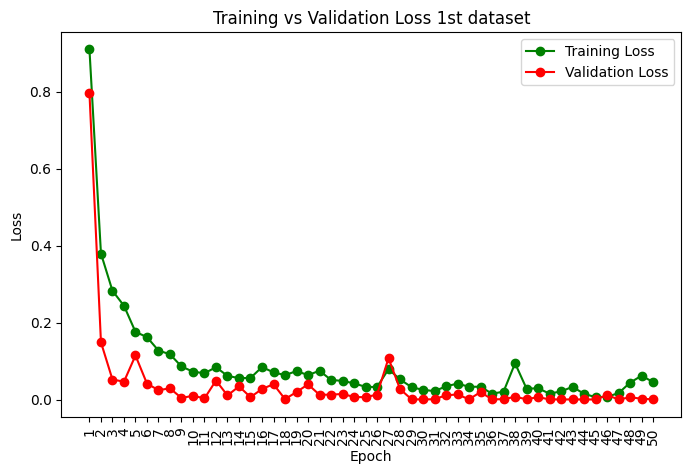

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Create a list of epoch numbers starting from 1
epochs = range(1, len(train_losses) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='green', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss 1st dataset')
plt.legend()

# Ensure x-axis ticks are at integer epoch numbers
plt.xticks(epochs, rotation=90)

plt.show()

In [ ]:
# Find the minimum validation loss and its epoch
min_val_loss = min(val_losses)
min_epoch = val_losses.index(min_val_loss) + 1  # +1 because epochs start at 1

print(f"Minimum validation loss: {min_val_loss:.4f} at epoch {min_epoch}")

Minimum validation loss: 0.0001 at epoch 44


## Testing

In [ ]:
# Load best weights before testing
model.load_state_dict(torch.load('Neu_scratch.pth'))

<All keys matched successfully>

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100*correct / total:.4f}%")


In [ ]:
test_model(model,test_loader)

Test Accuracy: 100.0000%


In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              80
       BatchNorm2d-2            [-1, 8, 64, 64]              16
         MaxPool2d-3            [-1, 8, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
       BatchNorm2d-5           [-1, 16, 32, 32]              32
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           4,640
       BatchNorm2d-8           [-1, 32, 16, 16]              64
         MaxPool2d-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          18,496
      BatchNorm2d-11             [-1, 64, 8, 8]             128
        MaxPool2d-12             [-1, 64, 4, 4]               0
           Linear-13                   [-1, 64]          65,600
          Dropout-14                   

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


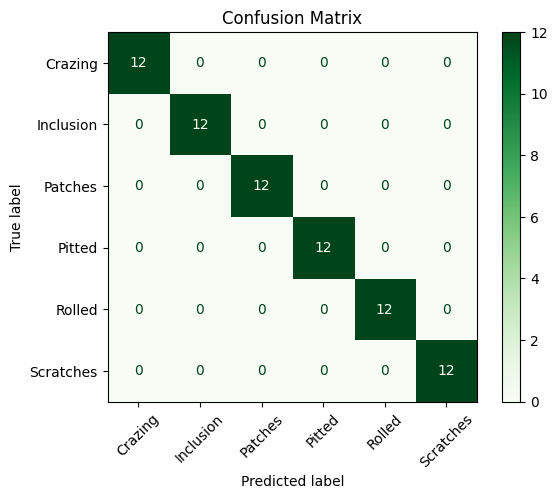

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       1.00      1.00      1.00        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      1.00      1.00        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



In [ ]:
from sklearn.metrics import classification_report

cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes  # Automatically extracted from folder names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Greens, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))

## Visualizations

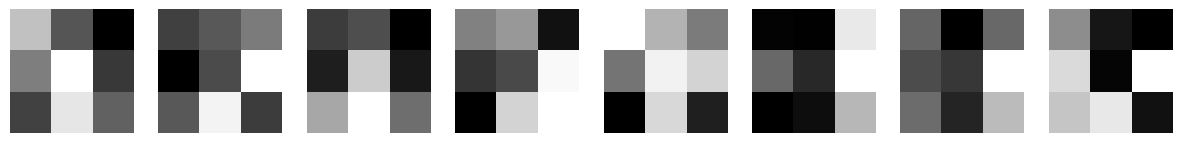

In [ ]:
import matplotlib.pyplot as plt

# Visualize weights of first conv layer
weights = model.conv1.weight.data.cpu()  # shape: (out_channels, in_channels, kH, kW)

fig, axes = plt.subplots(1, weights.shape[0], figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(weights[i, 0], cmap='gray')
    ax.axis('off')
plt.show()


# Visualize feature maps for one input image
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # add batch dimension
        x = model.bn1(model.conv1(x))      # first conv layer + batch norm (before relu/pool)
        x = x.cpu().squeeze(0)              # remove batch dim

    fig, axes = plt.subplots(1, x.shape[0], figsize=(15,5))
    for i, ax in enumerate(axes):
        ax.imshow(x[i], cmap='gray')
        ax.axis('off')
    plt.show()


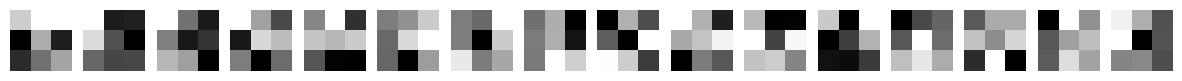

In [ ]:
import matplotlib.pyplot as plt

# Visualize weights of first conv layer
weights = model.conv2.weight.data.cpu()  # shape: (out_channels, in_channels, kH, kW)

fig, axes = plt.subplots(1, weights.shape[0], figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(weights[i, 0], cmap='gray')
    ax.axis('off')
plt.show()


# Visualize feature maps for one input image
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # add batch dimension
        x = model.bn2(model.conv2(x))      # second conv layer + batch norm (before relu/pool)
        x = x.cpu().squeeze(0)              # remove batch dim

    fig, axes = plt.subplots(1, x.shape[0], figsize=(15,5))
    for i, ax in enumerate(axes):
        ax.imshow(x[i], cmap='gray')
        ax.axis('off')
    plt.show()


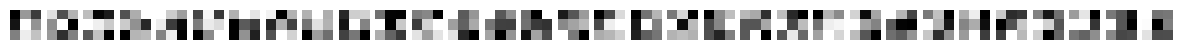

In [ ]:
import matplotlib.pyplot as plt

# Visualize weights of first conv layer
weights = model.conv3.weight.data.cpu()  # shape: (out_channels, in_channels, kH, kW)

fig, axes = plt.subplots(1, weights.shape[0], figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(weights[i, 0], cmap='gray')
    ax.axis('off')
plt.show()


# Visualize feature maps for one input image
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # add batch dimension
        x = model.bn3(model.conv3(x))      # third conv layer + batch norm (before relu/pool)
        x = x.cpu().squeeze(0)              # remove batch dim

    fig, axes = plt.subplots(1, x.shape[0], figsize=(15,5))
    for i, ax in enumerate(axes):
        ax.imshow(x[i], cmap='gray')
        ax.axis('off')
    plt.show()


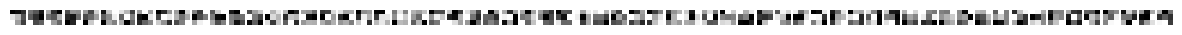

In [ ]:
import matplotlib.pyplot as plt

# Visualize weights of first conv layer
weights = model.conv4.weight.data.cpu()  # shape: (out_channels, in_channels, kH, kW)

fig, axes = plt.subplots(1, weights.shape[0], figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(weights[i, 0], cmap='gray')
    ax.axis('off')
plt.show()


# Visualize feature maps for one input image
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # add batch dimension
        x = model.bn4(model.conv4(x))      # forth conv layer + batch norm (before relu/pool)
        x = x.cpu().squeeze(0)              # remove batch dim

    fig, axes = plt.subplots(1, x.shape[0], figsize=(15,5))
    for i, ax in enumerate(axes):
        ax.imshow(x[i], cmap='gray')
        ax.axis('off')
    plt.show()


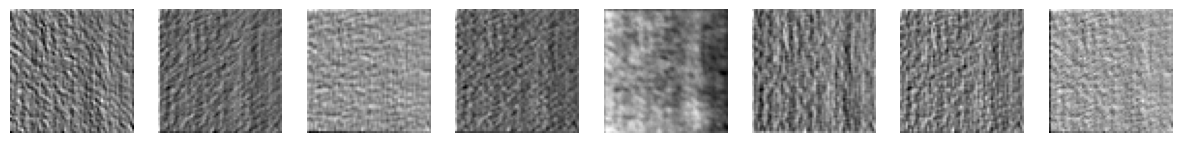

In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))

# Run a batch through the model
images, labels = next(iter(test_loader))
images = images.to(device)
output = model(images)

# activation['conv1'] now holds the feature maps of conv1
act = activation['conv1'][0].cpu()  # first image in batch

# Plot some feature maps
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(act[i], cmap='gray')
    axes[i].axis('off')
plt.show()

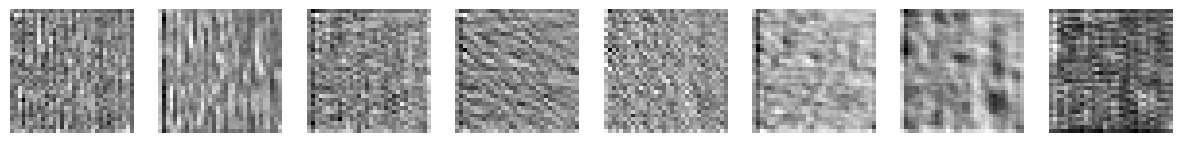

In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv2.register_forward_hook(get_activation('conv2'))

# Run a batch through the model
images, labels = next(iter(test_loader))
images = images.to(device)
output = model(images)

# activation['conv2'] now holds the feature maps of conv2
act = activation['conv2'][0].cpu()  # first image in batch

# Plot some feature maps
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(act[i], cmap='gray')
    axes[i].axis('off')
plt.show()

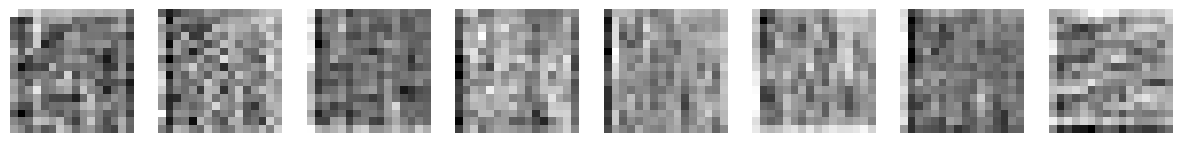

In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv3.register_forward_hook(get_activation('conv3'))

# Run a batch through the model
images, labels = next(iter(test_loader))
images = images.to(device)
output = model(images)

# activation['conv3'] now holds the feature maps of conv2
act = activation['conv3'][0].cpu()  # first image in batch

# Plot some feature maps
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(act[i], cmap='gray')
    axes[i].axis('off')
plt.show()

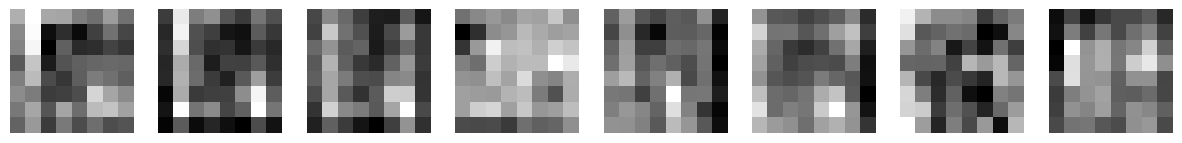

In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv4.register_forward_hook(get_activation('conv4'))

# Run a batch through the model
images, labels = next(iter(test_loader))
images = images.to(device)
output = model(images)

# activation['conv4'] now holds the feature maps of conv4
act = activation['conv4'][0].cpu()  # first image in batch

# Plot some feature maps
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(act[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# **Transfer Learning - 1 fc layer unfrozen**

This part explores transfer learning using a pretrained model. Only the final fully connected (fc) layer is unfrozen for training.

- Base model: pretrained CNN
- Only last fc layer is trainable
- Accuracy: 78.05%

## Load Dataset

In [ ]:
path = kagglehub.dataset_download("sayelabualigah/x-sdd")



root_dir=os.path.join(path,'X-DDD')

## Transform Images

In [ ]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

g = torch.Generator().manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load entire dataset
full_dataset = datasets.ImageFolder(root_dir, transform=transform)

# Split into train(70%), val(15%), test(15%)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

new_train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    worker_init_fn=seed_worker, generator=g
)

new_val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    worker_init_fn=seed_worker, generator=g
)

new_test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    worker_init_fn=seed_worker, generator=g
)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")
print(f"Classes: {full_dataset.classes}")

Train size: 951, Val size: 204, Test size: 205
Classes: ['finishing roll printing', 'iron sheet ash', 'oxide scale of plate system', 'oxide scale of temperature system', 'red iron', 'slag inclusion', 'surface scratch']


## Neural Network Architecture

In [ ]:
for name, param in model.named_parameters():
    if "fc2" not in name:  # freeze all except the last layer
        param.requires_grad = False
    else:
        param.requires_grad = True

num_new_classes = 7


model.fc2 = nn.Linear(64, num_new_classes).to(device)

# Ensure only this new layer's params require gradients
for param in model.fc2.parameters():
    param.requires_grad = True

## Training - Validation

In [ ]:
import torch.nn as nn
import torch

# Ensuring that if the dataset is imbalanced will be fixed
original_dataset = new_train_loader.dataset.dataset
class_names = original_dataset.classes
num_classes = len(class_names)

# Calculate class counts from the training subset
class_counts = [0] * num_classes
for _, label in new_train_loader:
    # The labels in the DataLoader correspond to the indices in the original dataset's classes
    for l in label:
        class_counts[l] += 1


total_count = sum(class_counts)
# Handle cases where a class might have zero samples in the training split
class_weights = [total_count / class_count if class_count > 0 else 0 for class_count in class_counts]

# Ensure class weights are positive for classes with samples
class_weights = [weight if weight > 0 else 1.0 for weight in class_weights] # Assign a small weight or 1 to empty classes if needed

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use these weights with the loss function
criterion_imbalanced = nn.CrossEntropyLoss(weight=class_weights)

print("Class Counts:", class_counts)
print("Calculated Class Weights:", class_weights)

Class Counts: [137, 82, 40, 143, 279, 172, 98]
Calculated Class Weights: tensor([ 6.9416, 11.5976, 23.7750,  6.6503,  3.4086,  5.5291,  9.7041])


In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.002)

In [ ]:
# Load new data and train as usual
train_losses_SDD, val_losses_SDD=train_model(model, new_train_loader, new_val_loader, criterion_imbalanced, optimizer, epochs=50,model_save_name='SDD_Tr_1lyr')

Epoch 1, Train Loss: 2.2985, Val Loss: 1.4057, Train Acc: 0.2482, Val Acc: 0.4853
Epoch 2, Train Loss: 1.5332, Val Loss: 1.1499, Train Acc: 0.4469, Val Acc: 0.5882
Epoch 3, Train Loss: 1.3556, Val Loss: 1.0119, Train Acc: 0.5289, Val Acc: 0.6765
Epoch 4, Train Loss: 1.2334, Val Loss: 0.9968, Train Acc: 0.5668, Val Acc: 0.7108
Epoch 5, Train Loss: 1.1733, Val Loss: 0.9326, Train Acc: 0.6057, Val Acc: 0.7010
Epoch 6, Train Loss: 1.1776, Val Loss: 0.9195, Train Acc: 0.5857, Val Acc: 0.7304
Epoch 7, Train Loss: 1.1121, Val Loss: 0.8960, Train Acc: 0.6141, Val Acc: 0.7108
Epoch 8, Train Loss: 1.0522, Val Loss: 0.8763, Train Acc: 0.6467, Val Acc: 0.6961
Epoch 9, Train Loss: 1.0824, Val Loss: 0.8477, Train Acc: 0.6246, Val Acc: 0.7108
Epoch 10, Train Loss: 1.0298, Val Loss: 0.8503, Train Acc: 0.6351, Val Acc: 0.7010
Epoch 11, Train Loss: 1.0279, Val Loss: 0.8403, Train Acc: 0.6320, Val Acc: 0.7402
Epoch 12, Train Loss: 1.0511, Val Loss: 0.8366, Train Acc: 0.6351, Val Acc: 0.7549
Epoch 13, Tra

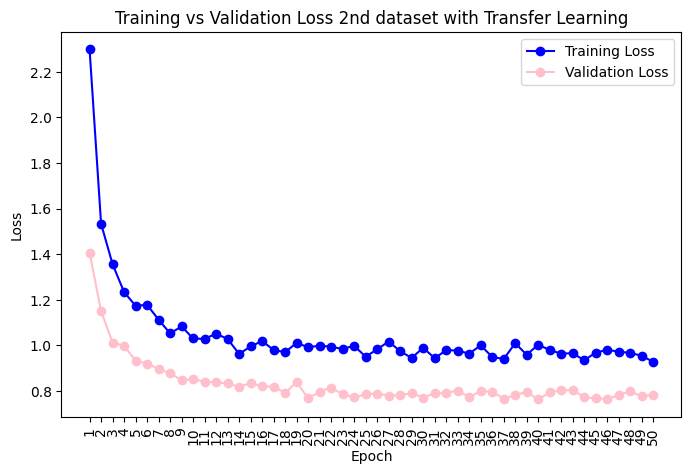

In [ ]:
epochs = range(1, len(train_losses_SDD) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_SDD, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses_SDD, label='Validation Loss', color='pink', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss 2nd dataset with Transfer Learning')
plt.legend()

# Ensure x-axis ticks are at integer epoch numbers
plt.xticks(epochs, rotation=90)


plt.show()

In [ ]:
# Find the minimum validation loss and its epoch
min_val_loss_SDD = min(val_losses_SDD)
min_epoch_SDD_trans = val_losses_SDD.index(min_val_loss_SDD) + 1  # +1 because epochs start at 1

print(f"Minimum validation loss for the 2nd dataset with transfer learning: {min_val_loss_SDD:.4f} at epoch {min_epoch_SDD_trans}")

Minimum validation loss for the 2nd dataset with transfer learning: 0.7620 at epoch 40


## Testing

In [ ]:
# Load best weights before testing
model.load_state_dict(torch.load('SDD_Tr_1lyr.pth'))

<All keys matched successfully>

In [ ]:
test_model(model,new_test_loader)

Test Accuracy: 78.0488%


In [ ]:
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              80
       BatchNorm2d-2            [-1, 8, 64, 64]              16
         MaxPool2d-3            [-1, 8, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
       BatchNorm2d-5           [-1, 16, 32, 32]              32
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           4,640
       BatchNorm2d-8           [-1, 32, 16, 16]              64
         MaxPool2d-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          18,496
      BatchNorm2d-11             [-1, 64, 8, 8]             128
        MaxPool2d-12             [-1, 64, 4, 4]               0
           Linear-13                   [-1, 64]          65,600
          Dropout-14                   

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in new_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

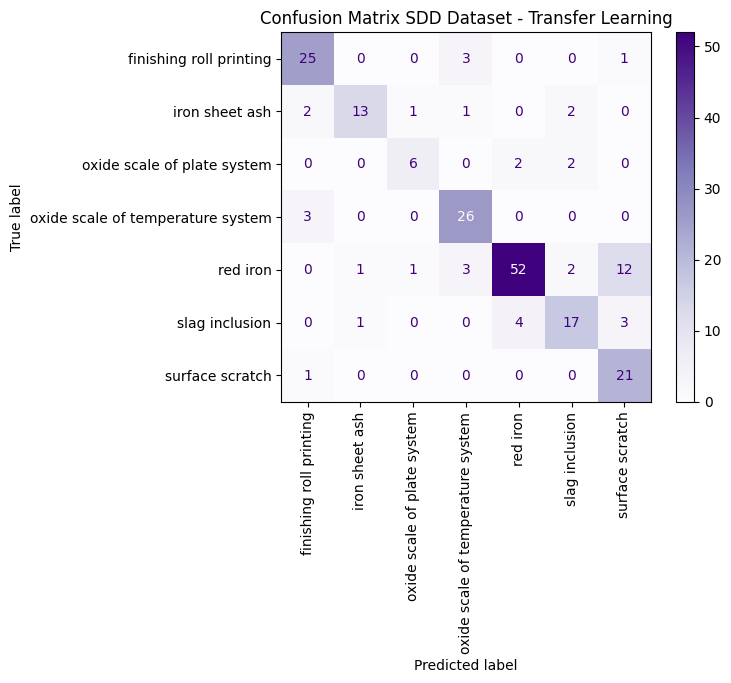

                                   precision    recall  f1-score   support

          finishing roll printing       0.81      0.86      0.83        29
                   iron sheet ash       0.87      0.68      0.76        19
      oxide scale of plate system       0.75      0.60      0.67        10
oxide scale of temperature system       0.79      0.90      0.84        29
                         red iron       0.90      0.73      0.81        71
                   slag inclusion       0.74      0.68      0.71        25
                  surface scratch       0.57      0.95      0.71        22

                         accuracy                           0.78       205
                        macro avg       0.77      0.77      0.76       205
                     weighted avg       0.80      0.78      0.78       205



In [ ]:
from sklearn.metrics import classification_report

cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes  # Automatically extracted from folder names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Purples, xticks_rotation=90)
plt.title("Confusion Matrix SDD Dataset - Transfer Learning")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))

# **Transfer Learning - 2 fcs layers unfrozen**

We expand the transfer learning experiment by unfreezing the last two fully connected layers, allowing more adaptation to the new dataset.

- Two fc layers are trainable
- Improved model flexibility
- Accuracy increased to 90.73%

## Neural Network Architecture

In [ ]:
model = CNN(num_classes=6).to(device)
model.load_state_dict(torch.load('Neu_scratch.pth'))


for name, param in model.named_parameters():
    if "fc2" not in name:
        param.requires_grad = False
    elif "fc1" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

num_new_classes = 7

model.fc1 = nn.Linear(64 * 4 * 4, 64).to(device)
model.fc2 = nn.Linear(64, num_new_classes).to(device)

# Ensure only this new layer's params require gradients
for param in model.fc2.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True

## Training - Validation

In [ ]:
import torch.nn as nn
import torch

# Ensuring that if the dataset is imbalanced will be fixed
original_dataset = new_train_loader.dataset.dataset
class_names = original_dataset.classes
num_classes = len(class_names)

# Calculate class counts from the training subset
class_counts = [0] * num_classes
for _, label in new_train_loader:
    # The labels in the DataLoader correspond to the indices in the original dataset's classes
    for l in label:
        class_counts[l] += 1


total_count = sum(class_counts)
# Handle cases where a class might have zero samples in the training split
class_weights = [total_count / class_count if class_count > 0 else 0 for class_count in class_counts]

# Ensure class weights are positive for classes with samples
class_weights = [weight if weight > 0 else 1.0 for weight in class_weights] # Assign a small weight or 1 to empty classes if needed

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use these weights with the loss function
criterion_imbalanced = nn.CrossEntropyLoss(weight=class_weights)

print("Class Counts:", class_counts)
print("Calculated Class Weights:", class_weights)

Class Counts: [137, 82, 40, 143, 279, 172, 98]
Calculated Class Weights: tensor([ 6.9416, 11.5976, 23.7750,  6.6503,  3.4086,  5.5291,  9.7041])


In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
# Load new data and train as usual
train_losses_SDD, val_losses_SDD=train_model(model, new_train_loader, new_val_loader, criterion_imbalanced, optimizer, epochs=50,model_save_name='SDD_Tr_2lyr')

Epoch 1, Train Loss: 1.4746, Val Loss: 1.0399, Train Acc: 0.5089, Val Acc: 0.7255
Epoch 2, Train Loss: 0.9868, Val Loss: 0.8060, Train Acc: 0.6930, Val Acc: 0.7745
Epoch 3, Train Loss: 0.8269, Val Loss: 0.7370, Train Acc: 0.7224, Val Acc: 0.7794
Epoch 4, Train Loss: 0.7704, Val Loss: 0.6292, Train Acc: 0.7676, Val Acc: 0.7892
Epoch 5, Train Loss: 0.6358, Val Loss: 0.6346, Train Acc: 0.7960, Val Acc: 0.8039
Epoch 6, Train Loss: 0.5664, Val Loss: 0.5378, Train Acc: 0.8160, Val Acc: 0.8333
Epoch 7, Train Loss: 0.5255, Val Loss: 0.5830, Train Acc: 0.8244, Val Acc: 0.7941
Epoch 8, Train Loss: 0.4670, Val Loss: 0.5328, Train Acc: 0.8486, Val Acc: 0.7990
Epoch 9, Train Loss: 0.4170, Val Loss: 0.5122, Train Acc: 0.8591, Val Acc: 0.8284
Epoch 10, Train Loss: 0.3828, Val Loss: 0.5443, Train Acc: 0.8644, Val Acc: 0.8431
Epoch 11, Train Loss: 0.3853, Val Loss: 0.4560, Train Acc: 0.8717, Val Acc: 0.8578
Epoch 12, Train Loss: 0.3409, Val Loss: 0.4742, Train Acc: 0.8927, Val Acc: 0.8431
Epoch 13, Tra

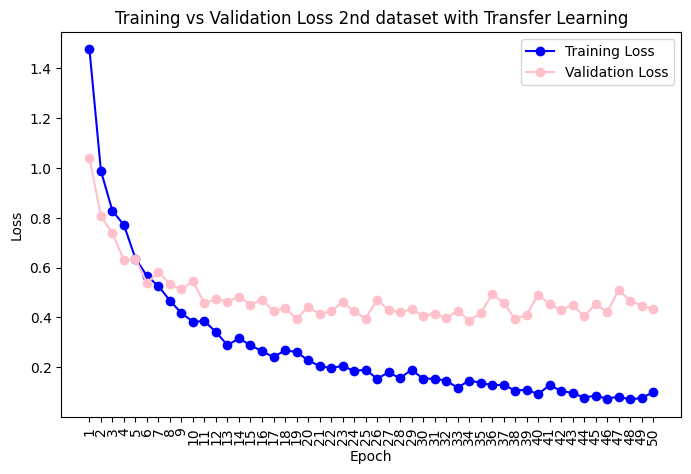

In [ ]:
epochs = range(1, len(train_losses_SDD) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_SDD, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses_SDD, label='Validation Loss', color='pink', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss 2nd dataset with Transfer Learning')
plt.legend()
# Ensure x-axis ticks are at integer epoch numbers
plt.xticks(epochs, rotation=90)


plt.show()

In [ ]:
# Find the minimum validation loss and its epoch
min_val_loss_SDD = min(val_losses_SDD)
min_epoch_SDD_trans = val_losses_SDD.index(min_val_loss_SDD) + 1  # +1 because epochs start at 1

print(f"Minimum validation loss for the 2nd dataset with transfer learning: {min_val_loss_SDD:.4f} at epoch {min_epoch_SDD_trans}")

Minimum validation loss for the 2nd dataset with transfer learning: 0.3875 at epoch 34


## Testing

In [ ]:
# Load best weights before testing
model.load_state_dict(torch.load('SDD_Tr_2lyr.pth'))

<All keys matched successfully>

In [ ]:
test_model(model,new_test_loader)

Test Accuracy: 90.7317%


In [ ]:
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              80
       BatchNorm2d-2            [-1, 8, 64, 64]              16
         MaxPool2d-3            [-1, 8, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
       BatchNorm2d-5           [-1, 16, 32, 32]              32
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           4,640
       BatchNorm2d-8           [-1, 32, 16, 16]              64
         MaxPool2d-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          18,496
      BatchNorm2d-11             [-1, 64, 8, 8]             128
        MaxPool2d-12             [-1, 64, 4, 4]               0
           Linear-13                   [-1, 64]          65,600
          Dropout-14                   

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in new_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

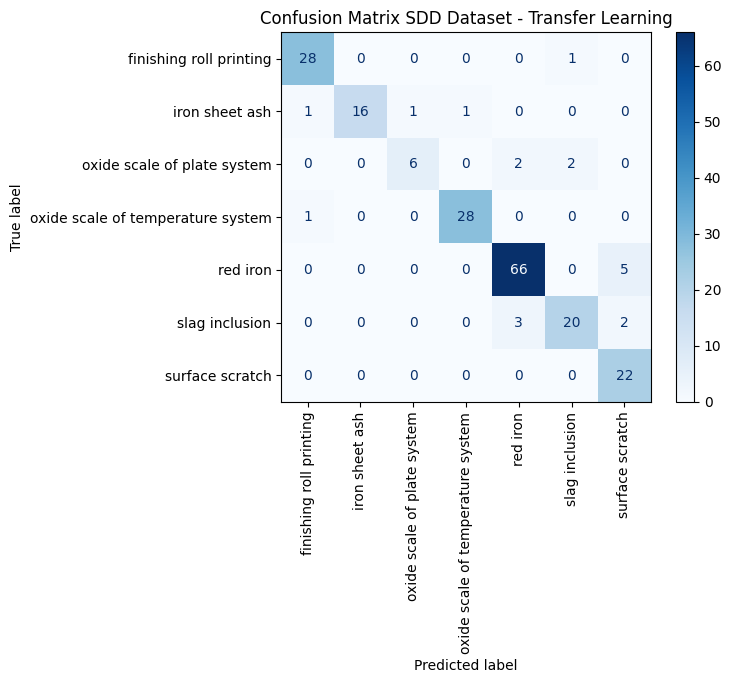

                                   precision    recall  f1-score   support

          finishing roll printing       0.93      0.97      0.95        29
                   iron sheet ash       1.00      0.84      0.91        19
      oxide scale of plate system       0.86      0.60      0.71        10
oxide scale of temperature system       0.97      0.97      0.97        29
                         red iron       0.93      0.93      0.93        71
                   slag inclusion       0.87      0.80      0.83        25
                  surface scratch       0.76      1.00      0.86        22

                         accuracy                           0.91       205
                        macro avg       0.90      0.87      0.88       205
                     weighted avg       0.91      0.91      0.91       205



In [ ]:
from sklearn.metrics import classification_report

cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes  # Automatically extracted from folder names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Confusion Matrix SDD Dataset - Transfer Learning")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))

# **From Scratch Learning - 2nd Dataset**

Here, we train a new model from scratch on the second dataset (X-SDD). The goal is to compare its performance with that of transfer learning approaches.

- New CNN trained from scratch
- Dataset: X-SDD
- Final accuracy: 91.71%

## Training - Validation

In [ ]:
model2 = CNN(num_classes=7).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.0005)
train_losses_SDD_fromscratch, val_losses_SDD_fromscratch = train_model(model2, new_train_loader, new_val_loader, criterion_imbalanced, optimizer2, epochs=50,model_save_name='SDD_Scratch')

Epoch 1, Train Loss: 1.7271, Val Loss: 1.9762, Train Acc: 0.4090, Val Acc: 0.1814
Epoch 2, Train Loss: 1.3666, Val Loss: 1.5880, Train Acc: 0.5794, Val Acc: 0.3824
Epoch 3, Train Loss: 1.0515, Val Loss: 0.8847, Train Acc: 0.6877, Val Acc: 0.7402
Epoch 4, Train Loss: 0.8035, Val Loss: 0.6990, Train Acc: 0.7550, Val Acc: 0.8137
Epoch 5, Train Loss: 0.6502, Val Loss: 0.5737, Train Acc: 0.7981, Val Acc: 0.8333
Epoch 6, Train Loss: 0.5278, Val Loss: 0.5244, Train Acc: 0.8318, Val Acc: 0.8333
Epoch 7, Train Loss: 0.4616, Val Loss: 0.5039, Train Acc: 0.8580, Val Acc: 0.8284
Epoch 8, Train Loss: 0.4258, Val Loss: 0.4647, Train Acc: 0.8570, Val Acc: 0.8382
Epoch 9, Train Loss: 0.3341, Val Loss: 0.3883, Train Acc: 0.8959, Val Acc: 0.8775
Epoch 10, Train Loss: 0.3451, Val Loss: 0.5359, Train Acc: 0.8791, Val Acc: 0.8333
Epoch 11, Train Loss: 0.2620, Val Loss: 0.3753, Train Acc: 0.9180, Val Acc: 0.8725
Epoch 12, Train Loss: 0.2104, Val Loss: 0.4108, Train Acc: 0.9338, Val Acc: 0.8676
Epoch 13, Tra

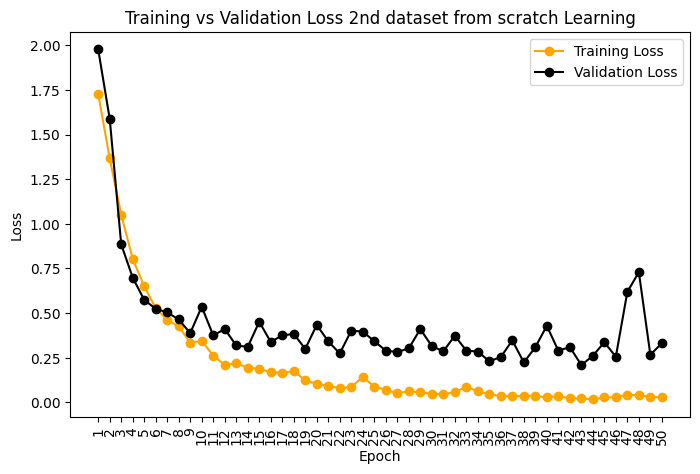

In [ ]:
epochs = range(1, len(train_losses_SDD_fromscratch) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_SDD_fromscratch, label='Training Loss', color='orange', marker='o')
plt.plot(epochs, val_losses_SDD_fromscratch, label='Validation Loss', color='black', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss 2nd dataset from scratch Learning')
plt.legend()

# Ensure x-axis ticks are at integer epoch numbers
plt.xticks(epochs, rotation=90)

plt.show()

In [ ]:
# Find the minimum validation loss and its epoch
min_val_loss_SDD = min(val_losses_SDD_fromscratch)
min_epoch_SDD_scratch = val_losses_SDD_fromscratch.index(min_val_loss_SDD) + 1  # +1 because epochs start at 1

print(f"Minimum validation loss for the 2nd dataset with transfer learning: {min_val_loss_SDD:.4f} at epoch {min_epoch_SDD_scratch}")

Minimum validation loss for the 2nd dataset with transfer learning: 0.2096 at epoch 43


## Testing

In [ ]:
model2.load_state_dict(torch.load('SDD_Scratch.pth'))

<All keys matched successfully>

In [ ]:
test_model(model2,new_test_loader)


Test Accuracy: 91.7073%


In [ ]:
summary(model2, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              80
       BatchNorm2d-2            [-1, 8, 64, 64]              16
         MaxPool2d-3            [-1, 8, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
       BatchNorm2d-5           [-1, 16, 32, 32]              32
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           4,640
       BatchNorm2d-8           [-1, 32, 16, 16]              64
         MaxPool2d-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          18,496
      BatchNorm2d-11             [-1, 64, 8, 8]             128
        MaxPool2d-12             [-1, 64, 4, 4]               0
           Linear-13                   [-1, 64]          65,600
          Dropout-14                   

In [ ]:
model2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in new_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

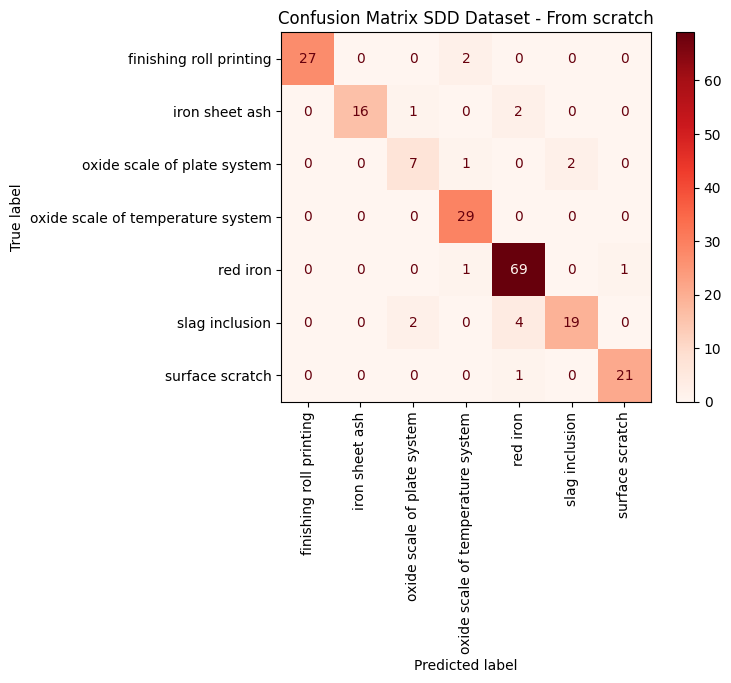

                                   precision    recall  f1-score   support

          finishing roll printing       1.00      0.93      0.96        29
                   iron sheet ash       1.00      0.84      0.91        19
      oxide scale of plate system       0.70      0.70      0.70        10
oxide scale of temperature system       0.88      1.00      0.94        29
                         red iron       0.91      0.97      0.94        71
                   slag inclusion       0.90      0.76      0.83        25
                  surface scratch       0.95      0.95      0.95        22

                         accuracy                           0.92       205
                        macro avg       0.91      0.88      0.89       205
                     weighted avg       0.92      0.92      0.92       205



In [ ]:
from sklearn.metrics import classification_report

cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes  # Automatically extracted from folder names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Reds, xticks_rotation=90)
plt.title("Confusion Matrix SDD Dataset - From scratch")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))